## Архитектура:

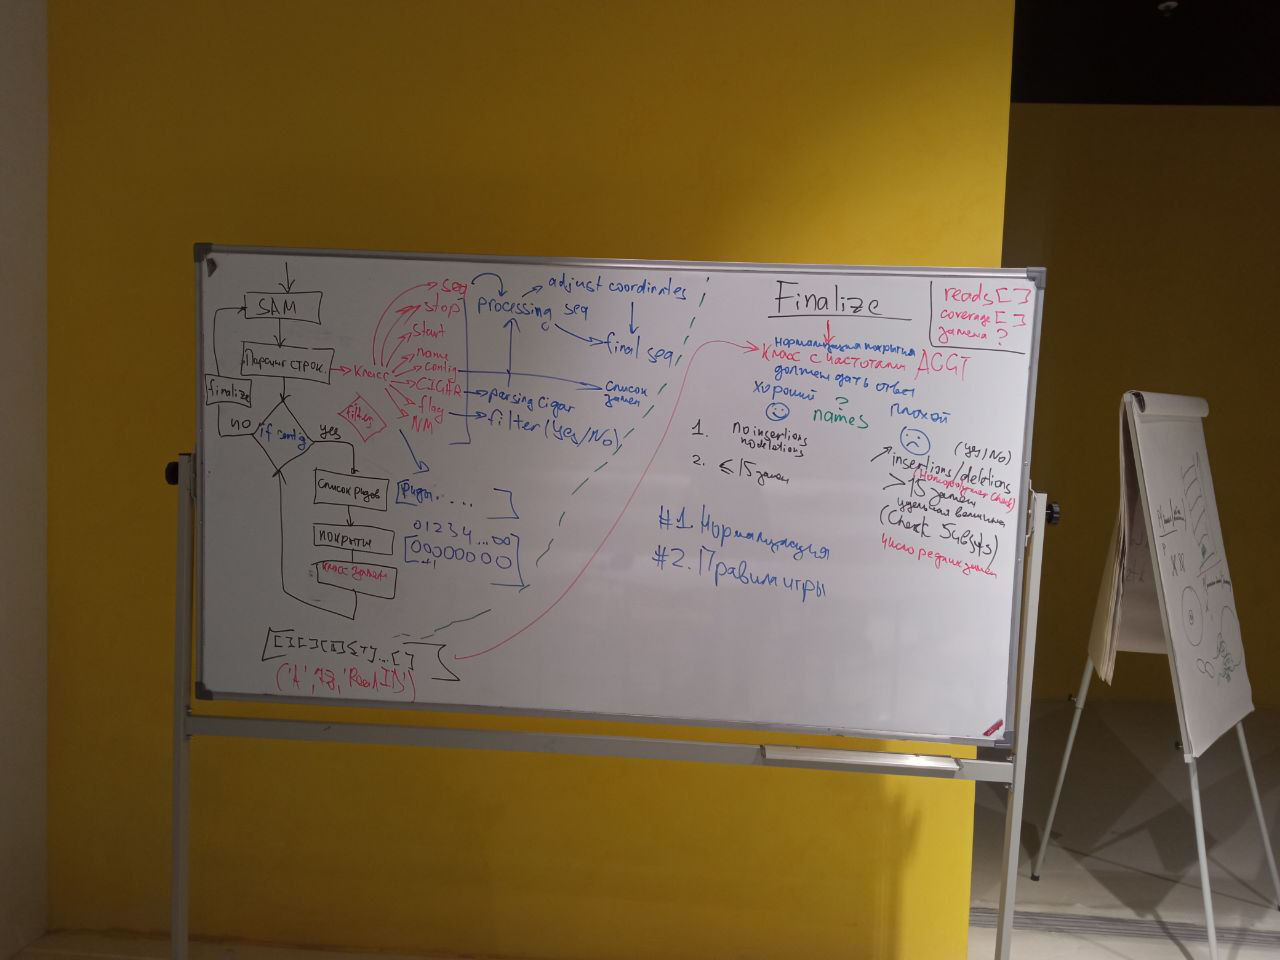

In [1]:
from PIL import Image
Image.open(r'план.png')

1. Цикл по cart_SAM-файлам
2. Каждый SAM-файл, открываю и читаю по строчке. 
3. Для каждого SAM файла список, куда элементы-списки ридов (прогнанных через сигар), по числу референсов.
4. Цикл по спискам (по числу референсов)
5. Цикл по элементам списка, ридам.
6.
7. Далее эти списки отправляю на "чистку"

In [1]:
import sys
import os
import pandas as pd
from Bio import SeqIO

In [2]:
class CIGAR(object):
    '''Класс для парсинга SAM файлов'''
    def __init__(self, name, ref_name, start, CIGAR, read): # задаем объект, где как атрибуты будут имя рида, флаг и тд
        self.name = name
        self.ref_name = ref_name
        self.start = start
        self.CIGAR = CIGAR
        self.read = read
        
    def Ref(self): # Подгрузим соответствующий референс в виде списка букв
        with open('All_refs.fasta', 'r') as refs:
            line = refs.readline()
            while line:
                if self.ref_name in line: # Если название референса из атрибутов совпадает с названием строки в фаста файле с референсами, следующую строку записываем как референс
                    line = refs.readline()
                    ref = list(line)
                line = refs.readline()
        return ref
    
    def ReadySeq(self):
        '''For input the self object, for output the seq is ready for comparing with reference'''
        cigar = list(self.CIGAR.strip()) #сделали список
        # для начала нужно сигар разбить на блоки и переделать цифры в инт. По идее олжно получиться int(61) str(S) int(37) str(M)...
        # Каждый символ пытаюсь перевести в инт, обработка исключений на буквы
        for i in range(len(cigar)): #пробуем каждый символ списка сделать интом
            try:
                cigar[i] = int(cigar[i])
            except ValueError:
                cigar[i] = cigar[i]

        # Потом объединяю цифры в одно число.
        cigar_new = []
        for i in range(len(cigar)): # если символ - строка - записываем его отдельно
            if type(cigar[i]) == str:
                cigar_new.append(cigar[i])                                    
            try:
                if type(cigar[i]) == type(cigar[i+1]) == type(cigar[i+2]) : # если три символа подряд это инт, объединяем их
                    cigar_new.append(int(str(cigar[i])+str(cigar[i+1])+str(cigar[i+2])))
                if type(cigar[i]) == type(cigar[i+1]) and type(cigar[i]) != type(cigar[i+2]) and type(cigar[i-1]) ==str:  # если два символа подряд одного типа (такое может быть только с инт), объединяем их  
                    cigar_new.append(int(str(cigar[i])+str(cigar[i+1])))
                if type(cigar[i+1]) == str and type(cigar[i-1]) == str: # если один инт - тоже записываем его
                    cigar_new.append(cigar[i])
            except IndexError: # это нужно на случай окончания строки, list index out of range
                continue
                
        # удобнее сделать словарь
        numbers = cigar_new[::2] # список с числом нуклеотидов
        clipping_type = [] # список с типом совпадений
        
        for i in range(1, len(cigar_new), 2): 
            clipping_type.append(cigar_new[i]);

        cigar_dict = [] # делаем словарь
        for i in range(len(numbers)):
            cigar_dict.append((numbers[i],clipping_type[i]))
            
        # Теперь прогоняем сам seq по строке cigar, для каждой буквы свое действие
        nucl_number = 0 # сразу столбец из data
        seq = self.read
        for e in cigar_dict:
            if e[1] == 'S':
                seq = seq[:nucl_number] + 'N' * e[0] + seq[nucl_number + e[0]:]
            if e[1] == 'D':
                seq = seq[:nucl_number] + ' ' * e[0] + seq[nucl_number:]
            if e[1] == 'H':
                continue # это пока, может быть hard clipping не вырезается
            if e[1] == 'I':
                seq = seq[:nucl_number] + seq[nucl_number + e[0]:]
            nucl_number += e[0]
        seq = seq.replace('N', '') 
        new_seq = self.start * ' ' + seq

        return new_seq

In [3]:
def RefCover(refs, reads):
    '''Делает словарь покрытий по конкретному референсу и сборке.
    На вход: Референс по буквам и Список ридов, 
    на выходе список словарей с покрытием для каждого нуклеотида в референсе'''
    ref_cover_list = [] # большой словарь для всех нуклеотидов, по всей длине референса
    for i in range(len(refs) + 1):
        cover_dict = {} # для каждого нуклеотида
        cover_dict['A, нуклеотид № {0:.0f}'.format(i+1)] = 0
        cover_dict['C, нуклеотид № {0:.0f}'.format(i+1)] = 0
        cover_dict['G, нуклеотид № {0:.0f}'.format(i+1)] = 0
        cover_dict['T, нуклеотид № {0:.0f}'.format(i+1)] = 0
        ref_cover_list.append(cover_dict)

    for read in reads:
        for nucl_number, nucl in enumerate(read):
                #print(nucl, nucl_number)
                if nucl == 'A':
                    ref_cover_list[nucl_number]['A, нуклеотид № {0:.0f}'.format(nucl_number + 1)]  += 1
                if nucl == 'T':
                    ref_cover_list[nucl_number]['T, нуклеотид № {0:.0f}'.format(nucl_number + 1)]  += 1
                if nucl == 'G':
                    ref_cover_list[nucl_number]['G, нуклеотид № {0:.0f}'.format(nucl_number + 1)]  += 1
                if nucl == 'C':
                    ref_cover_list[nucl_number]['C, нуклеотид № {0:.0f}'.format(nucl_number + 1)]  += 1

    # посчитаем покрытие для каждого нуклеотида
    cover_list = [] # большой словарь для всех нуклеотидов, по всей длине референса
    for i in range(len(refs) + 1):
        cover_dict = {} # для каждого нуклеотида
        cover_dict['A, нуклеотид № {0:.0f}'.format(i+1)] = 0
        cover_dict['C, нуклеотид № {0:.0f}'.format(i+1)] = 0
        cover_dict['G, нуклеотид № {0:.0f}'.format(i+1)] = 0
        cover_dict['T, нуклеотид № {0:.0f}'.format(i+1)] = 0
        cover_list.append(cover_dict)


    cover_abs = []
    for nucl_number, nucl in enumerate(ref_cover_list):
        cover = 0
        for key, value in nucl.items():
            cover += value
        for key, value in nucl.items():    
            if key == 'A, нуклеотид № {:.0f}'.format(nucl_number + 1):
                if cover == 0:
                    cover_list[nucl_number][key] =  0
                else:
                    cover_list[nucl_number][key] =  value * 100 / cover
            if key == 'T, нуклеотид № {:.0f}'.format(nucl_number + 1):
                if cover == 0:
                    cover_list[nucl_number][key] =  0
                else:
                    cover_list[nucl_number][key] =  value * 100 / cover
            if key == 'G, нуклеотид № {:.0f}'.format(nucl_number + 1):
                if cover == 0:
                    cover_list[nucl_number][key] =  0
                else:
                    cover_list[nucl_number][key] =  value * 100 / cover
            if key == 'C, нуклеотид № {:.0f}'.format(nucl_number + 1):
                if cover == 0:
                    cover_list[nucl_number][key] =  0
                else:
                    cover_list[nucl_number][key] =  value * 100 / cover
        cover_abs.append(cover)     
    return cover_list, cover_abs

In [4]:
def AllChanges(refs, reads, Names):
    '''Смотрим на все существующие замены в этой сборке для этой хромосомы.
        На вход берем референс и риды сборки. На выходе получаем список списков, для каждого рида свой список.
        Внутри два элемента, номер рида и номер нуклеотида с типом замены'''
    changing = []
    for nucl_number, nucl in enumerate(refs): # для всех нуклеотидов референса
        for seq_number, seq in enumerate(reads): # для каждого рида сборки
            #print(seq[nucl_number])
            try:
                if seq[nucl_number] != ' ': # если нуклеотид рида существует в этой позиции
                    if nucl != seq[nucl_number]: # если нуклеотид референса не равен нуклеотиду рида
                        changing.append([Names[seq_number], 
                                         '{0:s}, нуклеотид № {1:.0f}'.format(seq[nucl_number], nucl_number +1), len(seq)])                 
            except IndexError:
                continue
    return changing

In [5]:
def ReadWithChanges(AllChanges):
    '''Считаем количество ридов с заменами и считаем число замен в риде.
        На вход подаем список списков из функции AllChanges.
        На выход список кортежей с номером рида и числом замен в этом риде'''
    read_with_change = [] # Риды с заменами
    for e in AllChanges: # Для каждого элемента из общего файла существующих замен:
        read_with_change.append(e[0]) # Добавляем сюда номер рида

    change = [] 
    for read in read_with_change:
        change.append(('{0:s}'.format(read), read_with_change.count(read))) # Считаем сколько раз этот рид встретился в наборе всех замен
    read_with_change = list(set(change)) # Берем сет от этого набора:
    return read_with_change

In [6]:
def Cleaning(ReadWithChanges, AllChanges, RefCover):
    candidate_for_remove = [] # список кандидатов на удаление
    for read_tuple in ReadWithChanges: # для всех ридов с заменами:
        if read_tuple[1] >= 2: # Более скольки замен должно быть в риде
            candidate_for_remove.append(read_tuple)
        # те риды, где есть инсерция и делеция, тоже попадают в список
       # if 'I' in data.loc[data['Название рида'] == read_tuple[1]]['CIGAR'].iloc[0] or 'D' in data.loc[data['Название рида'] == read_tuple[0]]['CIGAR'].iloc[0]:
        #    candidate_for_remove.append(read_tuple)
    #candidate_for_remove = list(set(candidate_for_remove)) # сет, чтобы один рид не попал дважды
    #print(candidate_for_remove)

    count =[]
    for read_number, read in enumerate(candidate_for_remove): # в каждом риде с большим числом замен
        k = 0 # Счетчик редких замен
        for i, e in enumerate(AllChanges): # иду по списку всех возможных замен
            if read[0] == e[0]: # если совпадает название рида с ошибкой и название кандидата на удаление
                for cover_i, cover in enumerate(RefCover[0]): # смотрим словарь покрытия
                    for key, value in cover.items(): # key - тип нуклеотида с заменой и его номер, value - процент покрытия для этого типа замены
                        if key == e[1]: # когда нуклеотид совпадает с нуклеотидом из списка замен
                            if value * RefCover[1][cover_i] / max(RefCover[1]) < 35: # для скольки процентов ридов характнрна такая замена
                                #print('Процент замен в риде, относительно его длины:', read[1],'\n', 'Информация о риде и замене:',e, '\n','Процент такой замены в целом:',value)
                                k+=1
        if k !=0:
            count.append((read,k)) # сколько в риде всего замен, и сколько из них "Редкие"
    reads_for_remove = []
    for i in count:
        if i[1] / i[0][1] > 0.4: #если относительно всех замен рида более 10% из них редкие,
            reads_for_remove.append(i[0][0])
        
    return reads_for_remove

In [7]:
curpath = os.path.abspath(os.path.curdir) # зафиксируем папку
    
files_sam_list = [x for x in os.listdir(curpath) if x.startswith("cart_")] # endswith - кончается на (можно так сделать для начала)
path_sam_list = [os.path.join(curpath, x) for x in files_sam_list] # сделали путь ко всем sam файлам

# здесь будет цикл для перебора всех sam файлов
data = pd.read_csv(path_sam_list[0], sep = '\t',header=None, usecols=[0,3,9,5,1,2], index_col = False)
data.columns = ['Название рида','Flag','Ref','Начало рида', 'CIGAR','Рид']
data = data.loc[data['Flag'] != 2048] # чистка по флагам
data = data.loc[data['Flag'] != 2064]
data = data.reset_index(drop=True)
data

,Название рида,Flag,Ref,Начало рида,CIGAR,Рид
0,IonXpress_unpaired_ID61,0,UCE1293_Claster_0_Contig1,296,150M,TCACCACAGACCCAGAGCTCATTTATCTTTTGTCAGAGATGAAGCC...
1,IonXpress_unpaired_ID99,0,UCE13_Claster_0_Contig1,382,5S40M46S,GTGGCCAGACGGAAGCCACTCCTCAGTAAAAGGCACATGACAGCCC...
2,IonXpress_unpaired_ID120,0,UCE549_Claster_0_Contig1,218,85M,AGCTAAACCTGCTGGCCTACGTAGGCAGAGAGAGTCCCCAGAGGGC...
3,IonXpress_unpaired_ID199,0,UCE176_Claster_0_Contig1,290,40M1I45M,CCTGCTTTATTTGTGGTAGTCGGGTTAATGAGTCCACCAGCCCCAC...
4,IonXpress_unpaired_ID131,16,UCE1282_Claster_0_Contig1,915,166S30M9S,ATCCCAGGGGATACACTGCAGTGAACACTGCACTGGAGAATACTGT...
...,...,...,...,...,...,...
31478,IonXpress_unpaired_ID1583863,0,UCE691_Claster_0_Contig1,39,51M119S,TTTATTTAACTAGGCAAGTCAGTTAAGAACAAATTCTTATTTACAA...
31479,IonXpress_unpaired_ID1583937,0,UCE1001_Claster_2_Contig1,291,6M1I22M1I15M1I11M,TGACAGTTTTGAATTGCAGCATATGTTTACCCCCAAACCAGGCAAT...
31480,IonXpress_unpaired_ID1583960,0,UCE526_Claster_1_Contig1,450,159S45M,GACCTGAATTAATAAATAAGTCCTGAGTGAATGAGTGATTACAGAC...
31481,IonXpress_unpaired_ID1583978,0,UCE526_Claster_1_Contig1,458,56M130S,GGCAGGAAGGACCTCCTGTAGCGCTCTCTGGCACACCGTGGTGGGA...


In [8]:
# Вспомогательное
refs_in_sam = set(data["Ref"])
refs = []
reads = []
Cigar = []
Names = []
for i in range(len(data['Ref'])):
    if data['Ref'][i].encode() == "UCE4_Claster_0_Contig1".encode():
        reads.append(CIGAR(data.iloc[i][0], data.iloc[i][2], data.iloc[i][3], data.iloc[i][4], data.iloc[i][5]).ReadySeq())
        refs = CIGAR(data.iloc[i][0], data.iloc[i][2], data.iloc[i][3], data.iloc[i][4], data.iloc[i][5]).Ref()[:-1] # сам референс по буквам, перенос строки не берем
        Cigar.append(data.iloc[i][4])
        Names.append(data.iloc[i][0])

In [9]:
Cleaning(ReadWithChanges(AllChanges(refs, reads, Names)), AllChanges(refs, reads, Names), RefCover(refs, reads))

['IonXpress_unpaired_ID849320',
 'IonXpress_unpaired_ID1166527',
 'IonXpress_unpaired_ID1536886',
 'IonXpress_unpaired_ID336952',
 'IonXpress_unpaired_ID1042918',
 'IonXpress_unpaired_ID1258576',
 'IonXpress_unpaired_ID853733',
 'IonXpress_unpaired_ID1319569',
 'IonXpress_unpaired_ID856658',
 'IonXpress_unpaired_ID866425']

In [10]:
good_reads = []
for read in Names:
    if read not in Cleaning(ReadWithChanges(AllChanges(refs, reads, Names)), AllChanges(refs, reads, Names), RefCover(refs, reads)):
        good_reads.append(read + '\t')
len(good_reads)

44

In [15]:
with open(path_sam_list[0], "r") as file:
    with open("UCE4_cluster_0_contog_1.sam", 'w') as output:
        output.write(file.readline())
        output.write(file.readline())
        for lines in file:
            for read in good_reads:
                if read in lines:
                    output.write(lines)